In [89]:
# Enable horizontal scroll in shell outputs
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# [InterCom](https://github.com/Tecnologias-multimedia/intercom): Real-Time Audio Transmission

## Contents

1. What is InterCom?
2. Hiding the jitter.
3. Compression with DEFLATE.
4. A simple bit-rate control through quantization.
5. Removing intra-frame redundancy.
6. Removing intra-channel redundancy.
7. Future developments.

## 1. What is InterCom?

* InterCom is a [full-duplex](https://en.wikipedia.org/wiki/Duplex_(telecommunications)#FULL-DUPLEX) real-time [intercommunicator](https://en.wikipedia.org/wiki/Intercom), that currently only transmits [PCM](https://en.wikipedia.org/wiki/Pulse-code_modulation) audio.

### A [minimal](https://tecnologias-multimedia.github.io/study_guide/minimal/) implementation

* In [`minimal.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/minimal.py), the sender (of audio) divides a sequence of [frames](https://python-sounddevice.readthedocs.io/en/0.3.12/api.html) (two [stereo](https://en.wikipedia.org/wiki/Stereophonic_sound) [samples](https://en.wikipedia.org/wiki/Sampling_(signal_processing))) in chunks (of constant length) and each one is transmitted in an [UDP](https://en.wikipedia.org/wiki/User_Datagram_Protocol) packet.

* At the receiver, the sequence of frames is reconstructed and played.

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>Before running the next cell, please, check the mic and the speakers gains!</font><p>

In [5]:
# Interrupt with: Kernel -> Interrupt
!python ~/InterCom/src/minimal.py --show_stats -t 5

# Alternatively, run this if your system is too slow
#!python ~/InterCom/src/minimal.py --frames_per_second 8000 --frames_per_chunk 256 --show_stats -t 5

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) minimal: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.032 seconds
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 31.25
(INFO) minimal: frames_per_cycle = 8000.0

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=8000.0, frames_per_chunk=256, listening_port=4444, destination_address='localhost', destination_port=4444, filename=None, reading_time=None, show_stats=True, show_samples=False)

Using device:

   0 HDA Intel PCH: ALC3246 Analog (hw:0,0), ALSA (2 in, 2 out)
   1 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   2 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   3 HDA Intel PCH: HDMI 2 (hw:0,8), ALS

## 2. [Hiding](https://tecnologias-multimedia.github.io/study_guide/latency/) the [packet jitter](https://en.wikipedia.org/wiki/Packet_delay_variation)

* The communication network usually delays a random amount of time the transmission of the chunks, i.e., generates a jitter (packet delay variation during the transmission of a sequence of packets).

* This jitter can be hiden through the [buffering](https://tecnologias-multimedia.github.io/study_guide/buffering/) (delaying) of the received chunks.

![With and without buffering](https://tecnologias-multimedia.github.io/study_guide/latency/graphics/timelines.svg)
<!-- ![With and without buffering](/home/vruiz/timelines.svg)
![With and without buffering](./tmp/timelines.svg)
![With and without buffering](../../../timelines.svg) -->

* The buffer size depends on the user's preferences (the larger the buffer, the lower the number of lost chunks).

### Measuring the jitter in my host

In [6]:
!ping -c 10 localhost

PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.017 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=0.069 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=0.104 ms
64 bytes from localhost (127.0.0.1): icmp_seq=4 ttl=64 time=0.075 ms
64 bytes from localhost (127.0.0.1): icmp_seq=5 ttl=64 time=0.064 ms
64 bytes from localhost (127.0.0.1): icmp_seq=6 ttl=64 time=0.038 ms
64 bytes from localhost (127.0.0.1): icmp_seq=7 ttl=64 time=0.059 ms
64 bytes from localhost (127.0.0.1): icmp_seq=8 ttl=64 time=0.065 ms
64 bytes from localhost (127.0.0.1): icmp_seq=9 ttl=64 time=0.066 ms
64 bytes from localhost (127.0.0.1): icmp_seq=10 ttl=64 time=0.027 ms

--- localhost ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9221ms
rtt min/avg/max/mdev = 0.017/0.058/0.104/0.023 ms


![RTT and ping](https://tecnologias-multimedia.github.io/study_guide/latency/graphics/ping_timeline.svg)
$t_t =$ Transmission Time, $t_p =$ Propagation Time

* The `min/avg/max/mdev` represents the minimum [RTT](https://en.wikipedia.org/wiki/Round-trip_delay) / average RTT / maximum RTT / standard deviation of the RTT.
* Latency is the RTT divided by 2.

![RTT and ping](https://tecnologias-multimedia.github.io/study_guide/latency/graphics/ping_timeline.svg)
<center>$t_t =$ Transmission Time, $t_p =$ Propagation Time</center>

* Usually, the jitter that we want to hide is the `mdev`/2.
* Unfortunately, `localhost` is too good to simulate typical transmissions scenarios :-/

### How is the jitter in the Internet?

In [7]:
!ping -c 10 8.8.8.8 # Google DNS

PING 8.8.8.8 (8.8.8.8) 56(84) bytes of data.
64 bytes from 8.8.8.8: icmp_seq=1 ttl=116 time=21.4 ms
64 bytes from 8.8.8.8: icmp_seq=2 ttl=116 time=140 ms
64 bytes from 8.8.8.8: icmp_seq=3 ttl=116 time=17.2 ms
64 bytes from 8.8.8.8: icmp_seq=4 ttl=116 time=16.6 ms
64 bytes from 8.8.8.8: icmp_seq=5 ttl=116 time=16.9 ms
64 bytes from 8.8.8.8: icmp_seq=6 ttl=116 time=16.8 ms
64 bytes from 8.8.8.8: icmp_seq=7 ttl=116 time=18.4 ms
64 bytes from 8.8.8.8: icmp_seq=8 ttl=116 time=17.1 ms
64 bytes from 8.8.8.8: icmp_seq=9 ttl=116 time=19.7 ms
64 bytes from 8.8.8.8: icmp_seq=10 ttl=116 time=19.6 ms

--- 8.8.8.8 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9014ms
rtt min/avg/max/mdev = 16.625/30.387/140.081/36.595 ms


* If we want to simulate a real scenario using `localhost` we need to add some random latency.

### Increase latency and jitter for the `localhost` link
* Using [`tc`](https://man7.org/linux/man-pages/man8/tc.8.html) (Traffic Control).
* Example with:
    * Average latency = 20 ms (average RTT = 40 ms).
    * Average `mdev` = 5 ms.
    * [Perarson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between delays = 0.25 (1.0 means total [correlation](https://en.wikipedia.org/wiki/Correlation) between consecutive transmissions, 0.0 implies no correlation).
    * Statistical distribution of the RTTs = [normal](https://en.wikipedia.org/wiki/Normal_distribution).

In [51]:
avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>Please, before running the next cell, check that sudo request your password (open a terminal and run, for example, "sudo ls"). If a password is required, add the line "your_username ALL=(ALL) NOPASSWD: ALL" (for example) at the end of the "/etc/sudoers" file.</font><p>

In [55]:
!tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%


### (Optional) Remove the `tc` rule

In [54]:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 


### Let's see ... now

In [56]:
!ping -c 10 localhost

PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=668 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=597 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=646 ms
64 bytes from localhost (127.0.0.1): icmp_seq=4 ttl=64 time=463 ms
64 bytes from localhost (127.0.0.1): icmp_seq=5 ttl=64 time=621 ms
64 bytes from localhost (127.0.0.1): icmp_seq=6 ttl=64 time=702 ms
64 bytes from localhost (127.0.0.1): icmp_seq=7 ttl=64 time=740 ms
64 bytes from localhost (127.0.0.1): icmp_seq=8 ttl=64 time=569 ms
64 bytes from localhost (127.0.0.1): icmp_seq=9 ttl=64 time=520 ms
64 bytes from localhost (127.0.0.1): icmp_seq=10 ttl=64 time=507 ms

--- localhost ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9002ms
rtt min/avg/max/mdev = 462.887/603.349/740.042/84.817 ms


This configuration is better for our simulations.

### Let's listen again to minimal

In [35]:
!python ~/InterCom/src/minimal.py --show_stats -t 5

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) minimal: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename=None, reading_time=5, show_stats=True, show_samples=False)

Using device:

   0 HDA Intel PCH: ALC3246 Analog (hw:0,0), ALSA (2 in, 2 out)
   1 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   2 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   3 HDA Intel PCH: HDM

Quite bad :-/ The chunks are not arriving with a constant cadence to the receiver :

![Buffering](https://tecnologias-multimedia.github.io/study_guide/buffering/graphics/timelines.svg)

### And finally, let's hidden the jitter

In [36]:
!python ~/InterCom/src/buffer.py --show_stats -t 5 # 100 ms is the default buffering time

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) buffer: Unable to import argcomplete (optional)
(WARNING) buffer: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename=None, reading_time=5, show_stats=True

Much better!

### We can also transmit a audio file

In [37]:
!python ~/InterCom/src/minimal.py --show_stats -t 5 -f ~/InterCom/data/AviadorDro_LaZonaFantasma.oga

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) minimal: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename='/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga', reading_time=5, show_stats=True, show_samples=False)

Using device:

   0 HDA Intel PCH: ALC3246 Analog (hw:0,0), ALSA (2 in, 

In [38]:
!python ~/InterCom/src/buffer.py --show_stats -t 5 -f ~/InterCom/data/AviadorDro_LaZonaFantasma.oga

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) buffer: Unable to import argcomplete (optional)
(WARNING) buffer: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=F

## 3. [Compression with DEFLATE](https://tecnologias-multimedia.github.io/study_guide/BR_control/#x1-40001.2)

### Estimation of the [throughput](https://en.wikipedia.org/wiki/Throughput) of the `localhost` link

* Notice that the following technique depends heavely on the packet size, that using ping is limited to 64 KB (including the IP header). For this reason, our results will be only approximated :-/

In [47]:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo
!ping -c 1 -s 65507 localhost > /tmp/1
!cat /tmp/1
!grep rtt /tmp/1 | cut -f 5 -d "/" > /tmp/2
f = open("/tmp/2")
time = f.read()
print(time)

Error: Cannot delete qdisc with handle of zero.
qdisc noqueue 0: root refcnt 2 
PING localhost (127.0.0.1) 65500(65528) bytes of data.
65508 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.121 ms

--- localhost ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.121/0.121/0.121/0.000 ms
0.121



In [50]:
print("Gbps =", 65507*8/float(time)/2/1000/1000)

Gbps = 2.165289256198347


Too high! We need harder conditions for testing InterCom that without compression requires

\begin{equation}
\frac{44100\frac{\text{frames}}{\text{second}}\times 2\frac{\text{samples}}{\text{frame}}\times 2\frac{\text{bytes}}{\text{sample}}\times 8\frac{\text{bits}}{\text{byte}}}{1000} = 1411.2 ~\text{kbps} \approx 1.4~\text{Mbps}
\end{equation}

### Let's simulate (also) a throughput of 200 kbps

In [57]:
throughput = 200

In [60]:
# Definitive rules for the rest of experiments
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 1024kbit limit 1024kbit

### (Optional) Remove the previous `tc` rules

In [59]:
!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 


In [64]:
!ping -c 1 -s 65507 localhost > /tmp/1
!cat /tmp/1
!grep rtt /tmp/1 | cut -f 5 -d "/" > /tmp/2
f = open("/tmp/2")
time = f.read()
print(time)

PING localhost (127.0.0.1) 65507(65535) bytes of data.
65515 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=529 ms

--- localhost ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 528.966/528.966/528.966/0.000 ms
528.966



In [65]:
print("Throughput =", 65507*8/float(time)/2, "kbps")

Throughput = 495.35886994627253 kbps


###  Effect of insufficient link throughput
... or too many data to send.

In [66]:
!python ~/InterCom/src/buffer.py --show_stats -t 5 -f ~/InterCom/data/AviadorDro_LaZonaFantasma.oga

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) buffer: Unable to import argcomplete (optional)
(WARNING) buffer: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=F

### [DEFLATE](https://en.wikipedia.org/wiki/DEFLATE)

* The chunks can be compressed with [LZSS](https://en.wikipedia.org/wiki/Lempel-Ziv-Storer-Szymanski), that is based on [LZ77](https://github.com/vicente-gonzalez-ruiz/LZ77) and [Huffman Coding](https://vicente-gonzalez-ruiz.github.io/Huffman_coding/).

* We have choosen this text compressor codec because:
    1. It's fast.
    2. Works well when repeated strings are found at the input.
    3. Available in [The Standard Python Library](https://docs.python.org/3/library/) ([zlib](https://docs.python.org/3/library/zlib.html)).
    4. Generic (eats anything).

In [69]:
!python ~/InterCom/src/DEFLATE_byteplanes2.py --show_stats -t 5 -f ~/InterCom/data/AviadorDro_LaZonaFantasma.oga

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) buffer: Unable to import argcomplete (optional)
(WARNING) DEFLATE_raw: Unable to import argcomplete (optional)
(WARNING) DEFLATE_byteplanes2: Unable to import argcomplete (optional)
(WARNING) DEFLATE_byteplanes2: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "/home

Notice that a lot of chunks are still lost. DEFLATE is not enough!

## 4. A simple [bit-rate "control"](https://tecnologias-multimedia.github.io/study_guide/BR_control/#x1-60001.4) through [quantization](https://tecnologias-multimedia.github.io/study_guide/BR_control/#x1-50001.3)

* Quantization removes the less relevant information (mainly [electronic noise](https://en.wikipedia.org/wiki/Noise_(electronics)) if the quantization step size is small) and helps to increase the [compression ratio](https://en.wikipedia.org/wiki/Compression_ratio).
* In lossy signal compression, [dead-zone quantizers](https://github.com/vicente-gonzalez-ruiz/quantization/blob/master/digital_quantization.ipynb) are commonly used because they tend to generate 0's that like to entropy compressors.
* This class of quantizers can also operate by bit-planes when $\Delta$ is a power of 2.

* We use the quantizer
\begin{equation}
  k = \text{sgn}(x) \max\left(0, \left\lfloor \frac{\left| x \right|}{\Delta} + \frac{1}{2}\right\rfloor\right),
\end{equation}
where $k$ is the quantization index, and $\Delta$ is the quantization step size. The dequantizer is defined by:
\begin{equation}
  y = \Delta k.
\end{equation}

In [70]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np
import sounddevice as sd
from scipy import signal

In [71]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

In [72]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [73]:
x = np.linspace(-8, 8, 500) # Input samples
k2 = quantizer(x, quantization_step = 2)
y2 = dequantizer(k2, quantization_step = 2)
k3 = quantizer(x, quantization_step = 3)
y3 = dequantizer(k3, quantization_step = 3)

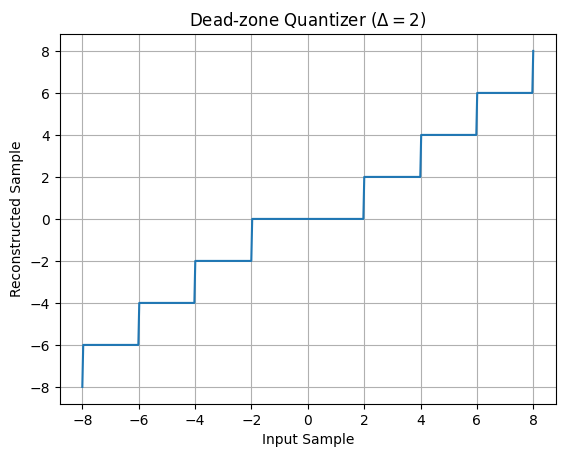

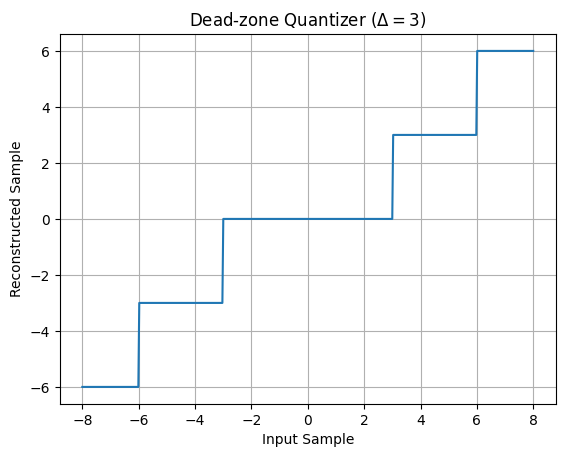

In [74]:
plot(x, y2, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(2))
plot(x, y3, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(3))

In [75]:
def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

In [76]:
x = np.arange(start = -8, stop = 9, step = 1)
k, y = q_deq(x, quantization_step = 3)
print("    Original samples =", x)
print("Quantization indexes =", k)
print(" Dequantized samples =", y)

    Original samples = [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]
Quantization indexes = [-2 -2 -2 -1 -1 -1  0  0  0  0  0  1  1  1  2  2  2]
 Dequantized samples = [-6 -6 -6 -3 -3 -3  0  0  0  0  0  3  3  3  6  6  6]


* In InterCom, we loosely "control" the bit-rate because a strict bit-rate control through the variation of $\Delta$ is computationally intensive (we must determine the [Rate/Distortion curve](https://en.wikipedia.org/wiki/Rate%E2%80%93distortion_theory) of the current chunk to find $\Delta$ before to quantize, compress and send it) and it's hard to compute in real-time.

* For this reason, the current implementation estimates the number of lost chunks per second (in the last second) and use this information to increase or decrease $\Delta$ for the chunks (of the next second).

In [77]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


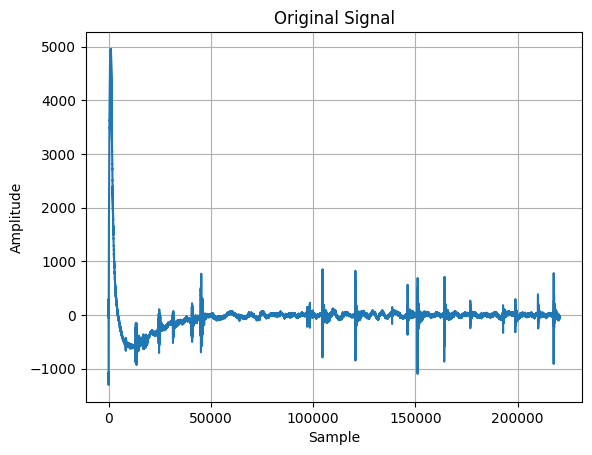

In [78]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Sample", "Amplitude", "Original Signal")

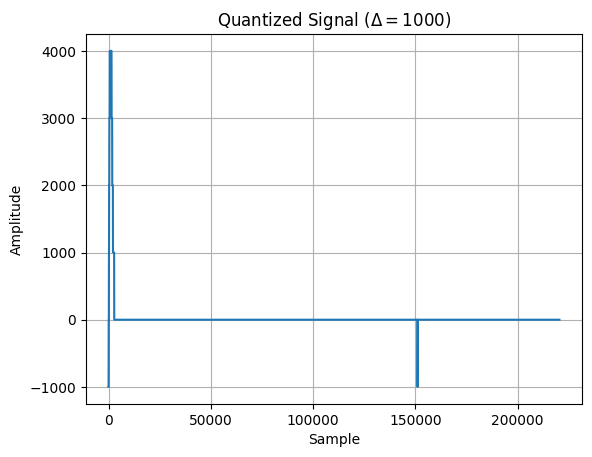

In [79]:
quantization_step = 1000
k, y = q_deq(x, quantization_step = 1000)
sd.play(y)
plot(np.linspace(0, len(y)-1, len(y)), y, "Sample", "Amplitude", "Quantized Signal ($\Delta={}$)".format(quantization_step))

In [80]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def RD_curve(x):
    points = []
    for q_step in range(1, 32768, 32):
        k, y = q_deq(x, q_step)
        rate = entropy_in_bits_per_symbol(k)
        distortion = RMSE(x, y)
        points.append((rate, distortion))
    return points

In [81]:
RD_points = RD_curve(x)

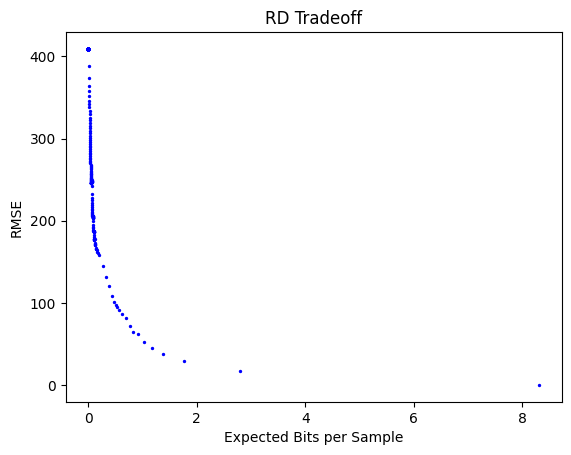

In [82]:
plt.title("RD Tradeoff")
plt.xlabel("Expected Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*RD_points), s=2, c='b', marker="o")
plt.show()

### Let's listen to the effect of the quantizer

The quantizer is controlled by the following algorithm:

1. Every second runs:
  \begin{equation}
    \left\{
    \begin{array}{ll}
      \Delta = 2\Delta & \quad\text{if}~L>2 \\
      \Delta = \frac{10}{11}\Delta & \quad\text{always}.
    \end{array}
    \right.
  \end{equation}

In [90]:
!python ~/InterCom/src/BR_control_conservative.py --show_stats -f ~/InterCom/data/AviadorDro_LaZonaFantasma.oga

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) buffer: Unable to import argcomplete (optional)
(WARNING) DEFLATE_raw: Unable to import argcomplete (optional)
(WARNING) DEFLATE_byteplanes3: Unable to import argcomplete (optional)
(WARNING) BR_control_no: Unable to import argcomplete (optional)
(WARNING) BR_control_conservative: Unable to import argcomplete (optional)
(WARNING) BR_control_conservative: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer 

The transmission has a smaller number of lost chunks, but the quantization noise is noticeable.

## 5. [Spatial (inter-channel) decorrelation](https://tecnologias-multimedia.github.io/study_guide/transform_coding/#x1-30001.1)
The samples of a (stereo) frame tend to have similar amplitudes. For this reason, we apply [Mid/Side stereo coding](https://en.wikipedia.org/wiki/Joint_encoding#M/S_stereo_coding) (before quantization).

* The MST (Mid/Side Transform) analysis transform
\begin{equation}
  w = Kx = \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}x,
  \label{eq:forward_transform_matrix_form}
\end{equation}
that can be also written as
\begin{equation}
  \begin{bmatrix}
    w_0 \\
    w_1
  \end{bmatrix}
  = 
  \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
  \begin{bmatrix}
    x_0 \\
    x_1
  \end{bmatrix}, \tag{1}
\end{equation}
where $x$ is a stereo frame, $K$ is the (forward or analysis)
transform matrix and $w=\begin{bmatrix} w_0 & w_1\end{bmatrix}^{\text
  T}$ is the corresponding [decomposition](https://en.wikipedia.org/wiki/Discrete_wavelet_transform#Example_in_image_processing).
  
* The synthesis transform is
\begin{equation}
  x = K^{-1}w
  \label{eq:inverse_transform}
\end{equation}
can be found from Eq. (1), where we
get that
\begin{equation}
  \begin{array}{rcl}
  w_0 & = & x_0 + x_1\\
  w_1 & = & x_0 - x_1.
  \end{array}
\end{equation}
By solving $x_0$ (adding) and $x_1$ (substracting) in
these equations, we obtain that
\begin{equation}
  \begin{array}{rcl}
  x_0 & = & \frac{1}{2}(w_0 + w_1)\\
  x_1 & = & \frac{1}{2}(w_0 - w_1),
  \end{array}
\end{equation}
that in matrix form becomes
\begin{equation}
  \begin{bmatrix}
    x_0 \\
    x_1
  \end{bmatrix}
  = \frac{1}{2}
  \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
  \begin{bmatrix}
    w_0 \\
    w_1
  \end{bmatrix}.
\end{equation}

Therefore,
\begin{equation}
  x = K^{-1}w = \frac{1}{2}K^{\text T}w = \frac{1}{2}Kw = \frac{1}{2}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}w.
  \label{eq:inverse_transform_matrix_form}
\end{equation}

In [91]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [92]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


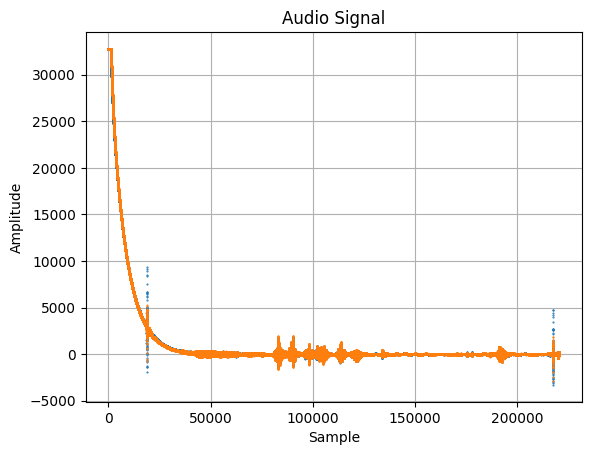

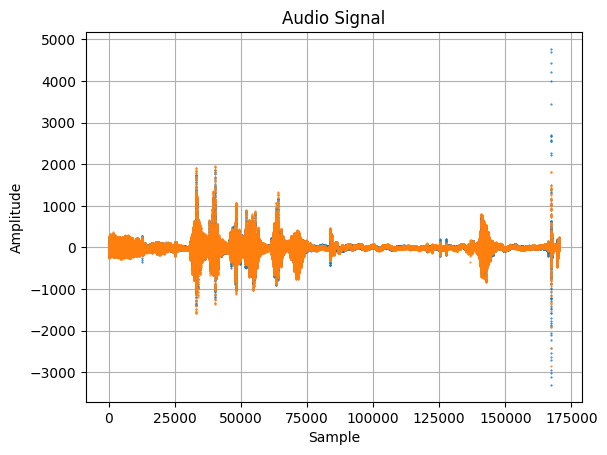

In [93]:
plot(x, "Sample", "Amplitude", "Audio Signal")
x = x[50000:]
plot(x, "Sample", "Amplitude", "Audio Signal")
sd.play(x)

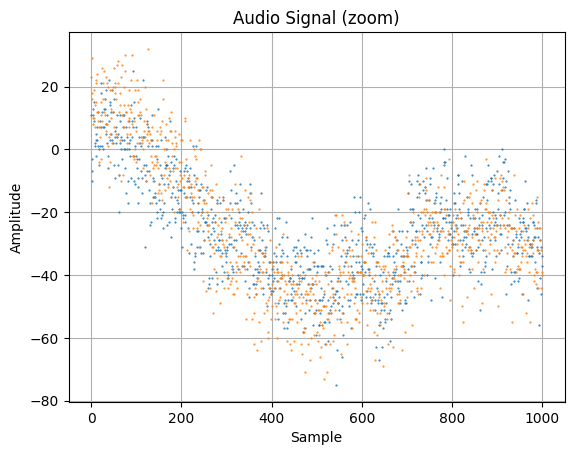

In [94]:
chunk = x[101000:102000]
plot(chunk, "Sample", "Amplitude", "Audio Signal (zoom)")

In [95]:
def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

In [96]:
w = MST_analyze(x)

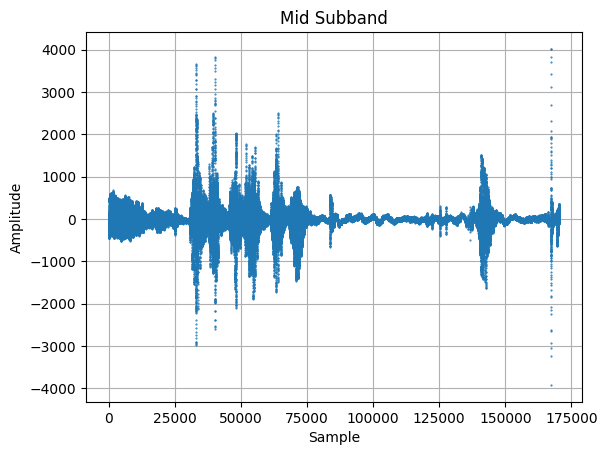

In [97]:
plot(w[:, 0], "Sample", "Amplitude", "Mid Subband")
sd.play(w[:, 0].astype(np.int16))

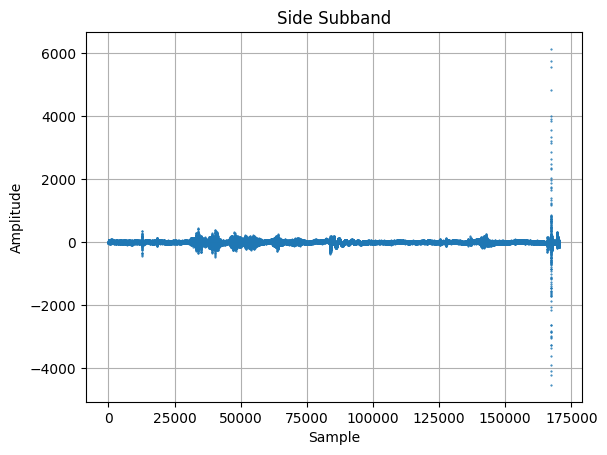

In [98]:
plot(w[:, 1], "Sample", "Amplitude", "Side Subband")
sd.play(w[:, 1].astype(np.int16))

In [99]:
K1 = np.array([1.0, 1.0])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([1.0, -1.0])
w2, h2 = signal.freqz(K2, fs=44100)

/tmp/ipykernel_2780/1969458427.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


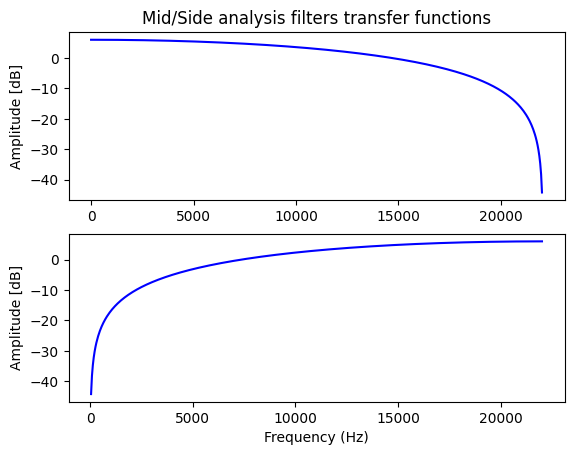

In [101]:
plt.subplot(211)
plt.title('Mid/Side analysis filters transfer functions')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.show()

* Notice that both filters have the same gain.

In [102]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def q_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [103]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)

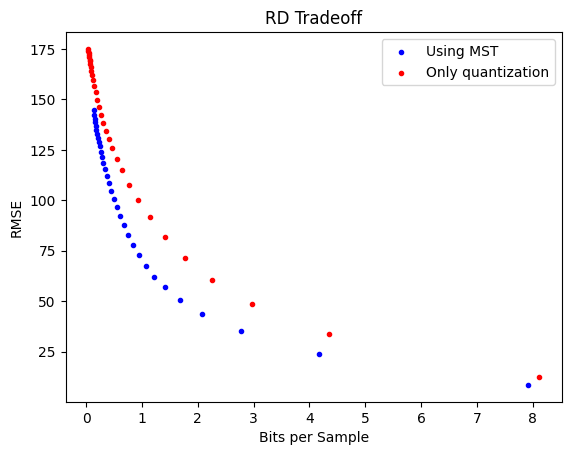

In [104]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='Using MST')
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='Only quantization')
plt.legend(loc='upper right')
plt.show()

* The same $\Delta$ has been used for both subbands $\mathbf{w}_0$ and $\mathbf{w}_1$,
because their gain is the same.

### Result of aplying the MST to InterCom

In [108]:
!python ~/InterCom/src/stereo_MST_coding_16.py --show_stats -f ~/InterCom/data/AviadorDro_LaZonaFantasma.oga

(WARNING) minimal: Unable to import argcomplete (optional)
(WARNING) buffer: Unable to import argcomplete (optional)
(WARNING) DEFLATE_raw: Unable to import argcomplete (optional)
(WARNING) DEFLATE_byteplanes3: Unable to import argcomplete (optional)
(WARNING) BR_control_no: Unable to import argcomplete (optional)
(WARNING) BR_control_conservative: Unable to import argcomplete (optional)
(WARNING) BR_control_add_lost: Unable to import argcomplete (optional)
(WARNING) stereo_MST_coding_16: Unable to import argcomplete (optional)
(WARNING) stereo_MST_coding_16: argcomplete not working :-/
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "/home/vruiz/InterCom/data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) mini

    7      45      24      95     111   18    8 ['  3638', '  3833'] ['13.4', '13.5'] [' 2.0', ' 0.6'] 4158 ['53648', '56266'] ['-31', '-30']
Avgs:      45      26     236     186   18   12 ['  3771', '  3834'] ['13.3', '13.3'] [' 3.7', ' 0.7']      ['28095', '29672'] ['-15', '-14']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU   standard deviation          entropy      bits/sample    Q        RMSE/sample        SNR[dB]
         sent   recv.    sent    recv.   Global          input audio      input audio           output                  10^4 *               

    8      45      21      50      80   17    8 ['  3678', '  3883'] ['13.4', '13.6'] [' 1.4', ' 0.5'] 7559 ['56369', '58977'] ['-30', '-29']
Avgs:      45      26     213     172   18   12 ['  3759', '  3841'] ['13.3', '13.4'] [' 3.4', ' 0.7']      ['31629', '33336'] ['-17', '-16']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU   standard deviation          entropy      bits/sample    Q        RMSE/sample        SNR[dB]
     

   19      45      46      25      26   14   11 ['  4845', '  4637'] ['13.8', '13.8'] [' 0.2', ' 0.4']169541 ['16857', '16638'] ['  0', '  0']
Avgs:      45      33     104      98   16   10 ['  4147', '  4118'] ['13.5', '13.5'] [' 1.7', ' 0.6']      ['31993', '32673'] ['-14', '-13']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU   standard deviation          entropy      bits/sample    Q        RMSE/sample        SNR[dB]
         sent   recv.    sent    recv.   Global          input audio      input audio           output                  10^4 *               

   20      45      56      25      31   16   21 ['  4589', '  4492'] ['13.7', '13.7'] [' 0.2', ' 0.5']154128 ['16626', '16575'] ['  0', '  0']
Avgs:      45      34     100      94   16   10 ['  4169', '  4137'] ['13.5', '13.6'] [' 1.6', ' 0.6']      ['31225', '31868'] ['-13', '-12']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU   standard deviation          entropy      bits/sample    Q        RMSE/sample        SNR[dB]
   

   31      46      32      26      18   16   14 ['  4970', '  4736'] ['13.8', '13.8'] [' 0.1', ' 0.3']785737 ['16909', '16797'] ['  0', '  0']
Avgs:      45      39      73      70   16   11 ['  4373', '  4312'] ['13.6', '13.6'] [' 1.1', ' 0.5']      ['25939', '26413'] [' -8', ' -8']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU   standard deviation          entropy      bits/sample    Q        RMSE/sample        SNR[dB]
         sent   recv.    sent    recv.   Global          input audio      input audio           output                  10^4 *               

   32      45      51      25      28   18   11 ['  4920', '  4788'] ['13.8', '13.8'] [' 0.2', ' 0.4']714306 ['16266', '16430'] ['  0', '  0']
Avgs:      45      39      72      69   16   11 ['  4390', '  4327'] ['13.6', '13.6'] [' 1.1', ' 0.5']      ['25637', '26101'] [' -8', ' -8']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU   standard deviation          entropy      bits/sample    Q        RMSE/sample        SNR[dB]
   

## 6. [Temporal (intra-channel) decorrelation](https://tecnologias-multimedia.github.io/study_guide/transform_coding/#x1-80001.2)

* The samples of each channel exhibit temporal redundancy. Therefore, we use a [Discrete Wavelet Transform (DWT)](https://tecnologias-multimedia.github.io/study_guide/temporal_decorrelation/) to exploit it (before quantization).

* The DWT can be implemented with PRFB's:
![DWT](https://tecnologias-multimedia.github.io/study_guide/transform_coding/graphics/cascade.svg)
where $l$ stands for low-frequency subband, and $h$ for high-frequency subband. $\downarrow 2$ represents a subsampling of one of each two samples, and $\uparrow 2$ the insertion of a 0 where the downsampler discarded a sample.

* Depending on how
$\phi$ (the analysis scaling function (low-pass frequency analysis filter)),
$\psi$ (the analysis wavelet function (high-pass frequency analysis filter),
$\tilde\phi$ (the synthesis scaling function (low-pass frequency synthesis filter),
and $\tilde\psi$ the synthesis wavelet function (high-pass frequency synthesis filter))
are defined, a different DWT is computed.

* The DWT generates the decomposition:
 \begin{equation*}
    | l^s_0 | h^s_0 | h^{s-1}_0 h^{s-1}_1 | h^{s-2}_0 h^{s-2}_1 h^{s-2}_2 h^{s-2}_3 | \cdots | h^1_0 h^1_1 \cdots h^1_{2^{n-1}-1} |,
  \end{equation*}
where $s$ represents the subband index, and each subband contains a set of coefficients.

* The [DWT in matrix](https://cseweb.ucsd.edu/classes/fa17/cse166-a/lec13.pdf) form.

### Let's see the DWT in action
Go to the shell and run:
```
pyenv activate tm
cd
python intercom/test/sounddevice/plot_input_stereo.py &
python intercom/test/transforms/rfft_hamming.py &
python intercom/test/transforms/dwt5.py &
python intercom/test/sounddevice/play_sine.py 440
```

In [ ]:
%matplotlib notebook
%run ~/InterCom//test/sounddevice/plot_input_stereo.py

### Exploring the DWT

In [ ]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab

In [ ]:
N = 512
levels = 4
wavelet_name = "haar"
#wavelet_name = "db5"
#wavelet_name = "db20"
#wavelet_name = "bior2.2"
#wavelet_name = "rbio2.2"
wavelet = pywt.Wavelet(wavelet_name)

In [ ]:
def energy_of_signal(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))

def spectrum(i):
    zeros = np.zeros(N)
    decomposition = pywt.wavedec(zeros, wavelet=wavelet, level=levels, mode="per")
    coefficients, slices = pywt.coeffs_to_array(decomposition)
    coefficients[i] = 1
    decomposition = pywt.array_to_coeffs(coefficients, slices, output_format="wavedec")
    samples = pywt.waverec(decomposition, wavelet=wavelet, mode="per")
    coefs = np.fft.rfft(samples)
    spectrum = np.sqrt(coefs.real*coefs.real + coefs.imag*coefs.imag)
    pylab.plot(np.linspace(0, len(spectrum)-1, len(spectrum)), spectrum)
    energy = energy_of_signal(samples)
    if i <= (N>>levels):
        type = "scaling f."
    else:
        type = "wavelet f."
    pylab.plot(np.linspace(0, len(samples)-1, len(samples)), samples, label=f"{i} ({energy:3.2f}) {type}")
    pylab.legend(loc='upper right')
    pylab.show()

In [ ]:
interact(spectrum, i=widgets.IntSlider(min=0, max=N-1, step=1, value=0));

### Let's quantify the DWT contribution

In [ ]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def DWT_analyze(x, levels):
    coefs = np.empty(x.shape, dtype=np.int32)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int16)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int16)
    return samples

def DWT_RD_curve(data, levels):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        k, y = q_deq(DWT_coefs, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [ ]:
x = x[:65536]
plot(x, "Sample", "Amplitude", "Side Subband")
sd.play(x.astype(np.int16))

In [ ]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x, levels = 5)

In [ ]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='Only quantization')
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='Using MST')
plt.scatter(*zip(*DWT_RD_points), c='g', marker=".", label='Using DWT')
plt.legend(loc='upper right')
plt.show()

### Result of aplying the DWT to InterCom

In [ ]:
!python ~/InterCom/src/intra_channel_decorrelation.py --show_stats

## 7. Future work
1. Currently, quantization minimizes the MSE (Mean Square Error). [Perceptual](https://en.wikipedia.org/wiki/Psychoacoustics) quantization should increase the compression ratio without increasing the perceived distortion.
2. Transmit [video](https://en.wikipedia.org/wiki/Video).

## Appendix

### Resumen

La transmisión en tiempo real de señales sobre redes de datos no dedicadas plantea problemas de latencia y de rendimiento. En este seminario se analizan las principales técnicas usadas para mitigar dichos problemas, y se evalúa su efectividad en InterCom (https://github.com/Tecnologias-multimedia/InterCom), una aplicación que permite la intercomunicación (mediante señales de audio) entre 2 usuarios conectados a Internet. Más información en https://github.com/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb.

The real-time transmission of signals over non-dedicated data networks generates latency and performance issues. In this seminar, the main techniques used to mitigate these problems are analyzed, and their effectiveness is evaluated in InterCom (https://github.com/Tecnologias-multimedia/InterCom), an application that allows intercommunication (through audio signals) between 2 users connected to the Internet. More information at https://github.com/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb.